In [1]:
import random

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# Global Variables
unique_characters = '0123456789+- ' # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99 # Highest value of integers contained in the queries
max_int_length = len(str(highest_integer)) # 
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = max_int_length + 1    # Maximum length of the answer string

# Savefiles
queryfile = 'queries_nmax={}.npz'.format(highest_integer)

# Model testing
gibberish = [
    '1 -1 ', '1 - 1', ' 1-1 ', ' 1- 1',
    '1 +1 ', '1 + 1', ' 1+1 ', ' 1+ 1',
    '10-10', '10- 1', ' 1-10', ' 1- 1',
    '10+10', '10+ 1', ' 1+10', ' 1+ 1',
    '99- 1', '99-10', ' 1-99', '10-99',
    '99+ 1', '99+10', ' 1+99', '10+99',
    '99+99', '99-99',
    ]
train_set_size = 0.8

In [2]:
def plot_training_history(histories, network_titles, title):
    df = pd.concat(histories, axis=1, keys=network_titles)
    df.columns = df.columns.swaplevel()

    fig, ax = plt.subplots(figsize=(8,5))
    df['loss'].plot(ax=ax, legend=False)
    df['val_loss'].plot(ax=ax, linestyle='--', legend=False)
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("Loss")
    ax.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(
        "images/{}_loss_maxint={}.png".format(title, highest_integer), 
        dpi=300
        )

    fig, ax = plt.subplots(figsize=(8,5))
    df['accuracy'].plot(ax=ax, legend=False)
    df['val_accuracy'].plot(ax=ax, linestyle='--', legend=False)
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(
        "images/{}_accuracy_maxint={}.png".format(title, highest_integer),
        dpi=300
        )

def create_data(highest_integer):
    """
    Creates the following data for all pairs of integers up to [highest integer]+[highest_integer]:

    @return:
    X_text: '151+ 21' -> text query of an arithmetic operation
    X_img : Stack of MNIST images corresponding to the query (7 x 28 x 28)
    y_text: ' 172' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (4 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """
    print("Creating Data")
    (MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(cross=True)
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []
    for i in range(highest_integer + 1):
        for j in range(highest_integer + 1):
            
            i_char = to_padded_chars(i, max_len=max_int_length)
            j_char = to_padded_chars(j, max_len=max_int_length)

            for sign in ['-', '+']:
                query_string = i_char + sign + j_char
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))
            
    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.
  
def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

def display_sample(n, fname):
    labs = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        plt.axis('off')
        plt.title(labs[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nSample ID: {n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.tight_layout()
    plt.savefig(fname, dpi=300)

def encode_labels(labels, max_len=4):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot 

def decode_labels(labels):
    pred = np.argmax(labels, axis=2)
    decoded_predictions = []
    for pred_i in pred:
        seq = ''.join([unique_characters[i] for i in pred_i])
        decoded_predictions.append(seq)
    return np.array(decoded_predictions)

def remove_invalid_answers(prediction):
    answer = np.zeros(prediction.shape)
    num_invalid = 0
    for i, p in enumerate(prediction):
        try:
            answer[i] = int(p)
        except:
            answer[i] = 0
            num_invalid += 1
    print("Found {} invalid predictions.".format(num_invalid))
    return answer

def calc_RMSE_of_model_predictions(model, inputs, outputs):
    hot_answers = model.predict(inputs)
    answers = decode_labels(hot_answers)
    try:
        answers = answers.astype(int)
    except:
        answers = remove_invalid_answers(answers)
    true_answers = outputs.astype(int)
    RMSE = np.sqrt(np.mean((answers - true_answers)**2))
    print("RMSE: {:.2f}".format(RMSE))
    return RMSE

def flatten(images):
    return images.reshape(
        images.shape[0], images.shape[1], 
        images.shape[2]*images.shape[3]
        )

def load_query_data(txt_x=True, txt_y=True):
    try:
        with open(queryfile, 'rb') as f:
            data = np.load(f)
            X_text = data['arr_0']
            X_img = data['arr_1']
            y_text = data['arr_2']
            y_img = data['arr_3']
    except:
        X_text, X_img, y_text, y_img = create_data(highest_integer)
        with open(queryfile, 'wb') as f:
            np.savez(f, X_text, X_img, y_text, y_img)
    if txt_x and txt_y:
        return X_text, y_text
    elif txt_x and not txt_y:
        return X_text, flatten(y_img)
    elif not txt_x and txt_y:
        return flatten(X_img), y_text
    elif not txt_x and not txt_y:
        return flatten(X_img), flatten(y_img)
    
"""
Image-to-text
"""
def setup_image_to_text_RNN(num_encoders, num_decoders):
    im2text = tf.keras.Sequential([
        tf.keras.layers.LSTM(
            units=num_encoders,
            input_shape=(max_query_length, 28*28),
            ),
        tf.keras.layers.RepeatVector(max_answer_length),
        tf.keras.layers.LSTM(
            units=num_decoders,
            return_sequences=True,
            ),
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(
                units=len(unique_characters),
                activation='softmax',
                )
            ),
    ])
    im2text.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics='accuracy',
        )
    im2text.summary()
    return im2text

def generate_images(cross=False, n=50):
    """
    Creates 'n' images of randm minus and plus signs. First create empty images
    then draw either one (minus) or two (plus) lines using 'cv2.line()'
    See https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html#cv2.line
    Inputs:
        cross - If True, draw plus signs, draw minus otherwise
        n - number of signs to create
    Returns:
        A np.ndarray op dim (n, 28, 28) containing n 28x28 images of the 
        specified sign.
    """
    import cv2

    x = np.random.randint(12, 16, (n, 2))
    y1 = np.random.randint(4, 8, n)
    y2 = np.random.randint(20, 24, n)
    
    blank = np.zeros([n, 28, 28])
    for i in range(n):
        line = cv2.line(
            img=blank[i],
            pt1=(y1[i], x[i,0]),
            pt2=(y2[i], x[i, 1]),
            color=(255,0,0),
            thickness=2,
            lineType =cv2.LINE_AA
            )
        if cross:
            line = cv2.line(
                img=blank[i],
                pt1=(x[i,0], y1[i]),
                pt2=(x[i, 1], y2[i]),
                color=(255,0,0),
                thickness=2,
                lineType =cv2.LINE_AA
                )
    return blank

def mask_train_and_test_set(N, train_set_fraction):
    permute = np.random.permutation(N)
    boundary = int(N*train_set_fraction)
    train = permute[:boundary]
    test = permute[boundary:]
    return train, test

In [3]:
# Load data (we need images for X and text for y)
X_img_flat, y_text = load_query_data(txt_x=False, txt_y=True)
y_text_onehot = encode_labels(y_text)
print(X_img_flat.shape, y_text.shape, y_text_onehot.shape)

(20000, 5, 784) (20000,) (20000, 3, 13)


In [4]:
train, test = mask_train_and_test_set(len(X_img_flat), train_set_size)

In [5]:
encoder_size = [256, 512, 1024, 256, 512, 1024,]
decoder_size = [128, 128, 128, 256, 256, 256,]
network_summaries = ['{}-{}'.format(e, d) for e, d in zip(encoder_size, decoder_size)]

In [6]:
histories = []
RMSEs = []
for enc, dec in zip(encoder_size, decoder_size):
    im2txt = setup_image_to_text_RNN(enc, dec)
    history = im2txt.fit(
        x=X_img_flat[train], y=y_text_onehot[train],
        validation_data=(X_img_flat[test], y_text_onehot[test]),
        epochs=20,
        batch_size=128,
        verbose=1,
    )
    im2txt.save('keras_models/im2txt_{}-{}'.format(enc, dec))
    RMSEs.append(calc_RMSE_of_model_predictions(im2txt, X_img_flat, y_text, 1000))
    histories.append(pd.DataFrame(history.history))
plot_training_history(histories, network_summaries, 'im2txt')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               1065984   
                                                                 
 repeat_vector (RepeatVector  (None, 3, 256)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 3, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 3, 13)            1677      
 ibuted)                                                         
                                                                 
Total params: 1,264,781
Trainable params: 1,264,781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


KeyboardInterrupt: 

In [7]:
def create_gibberish_images():
    print("Creating Gibberish")
    (MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(cross=True)
    image_mapping[' '] = np.zeros([1, 28, 28])
    gibberish_images = []
    for gib in gibberish:
        gib_img = []
        for n, char in enumerate(gib):
            image_set = image_mapping[char]
            index = np.random.randint(0, len(image_set), 1)
            gib_img.append(image_set[index].squeeze())
        gibberish_images.append(np.stack(gib_img))
    return np.stack(gibberish_images) / 255

In [8]:
gibberish_images = create_gibberish_images()
dotted_gibberish = [gib.replace(' ', '.') for gib in gibberish]
len(gibberish_images)

Creating Gibberish


26

In [9]:
def test_model_intuition(im2txtmodel):
    flat_gibberish = flatten(gibberish_images)
    hot_predict = im2txtmodel.predict(flat_gibberish)
    predict = decode_labels(hot_predict)
    return predict

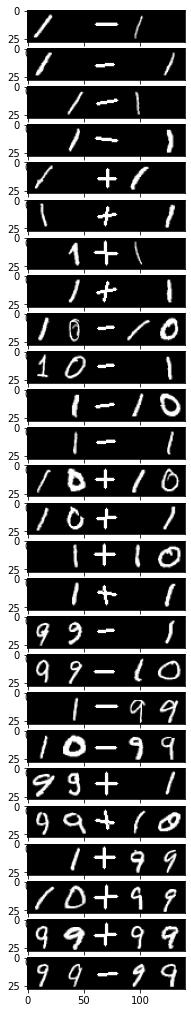

In [12]:
fig, axs = plt.subplots(len(gibberish_images), figsize=(6,18))
for ax, im in zip(axs, gibberish_images):
    ax.imshow(np.hstack(im), cmap='gray')
# plt.tight_layout()
plt.savefig('images/gibberish_images.png', dpi=300)

In [13]:
RMSEs = []
takes = []
for summ in network_summaries:
    network = tf.keras.models.load_model('keras_models/im2txt_{}'.format(summ))
    takes.append(test_model_intuition(network))
    RMSEs.append(calc_RMSE_of_model_predictions(network, X_img_flat[test], y_text[test]))
print(RMSEs)

Found 6 invalid predictions.
RMSE: 9.21
Found 4 invalid predictions.
RMSE: 8.31
Found 1 invalid predictions.
RMSE: 6.95


KeyboardInterrupt: 

In [ ]:
    
pred_df = pd.DataFrame(takes, index=network_summaries, columns=dotted_gibberish)
pred_df= pred_df.transpose()
with open('im2txt_predictions.tex', 'w') as f:
    pred_df.to_latex(f)
pred_df